## Import Libraries

In [1]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import GroupKFold
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import confusion_matrix, classification_report

import torch
import torch.nn as nn
import torch.nn.functional as F
from torch.utils.data import TensorDataset, DataLoader

import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)

## Load Data & Drop NaN Values

In [2]:
df = pd.read_csv("C:/Users/park9/pytorch/AI_class/data/WISDM_ar_v1.1_raw.txt",
                header=None,
                names=['user_id', 'activity', 'timestamp', 'x', 'y', 'z'],
                on_bad_lines='skip')

df['z'] = df['z'].astype(str).str.replace(";", "", regex=False).astype(float)

df.head()

,user_id,activity,timestamp,x,y,z
0,33,Jogging,49105962326000,-0.694638,12.680544,0.503953
1,33,Jogging,49106062271000,5.012288,11.264028,0.953424
2,33,Jogging,49106112167000,4.903325,10.882658,-0.081722
3,33,Jogging,49106222305000,-0.612916,18.496431,3.023717
4,33,Jogging,49106332290000,-1.184970,12.108489,7.205164


In [3]:
print(df.isna().sum())
df = df.dropna()

user_id      0
activity     0
timestamp    0
x            0
y            0
z            1
dtype: int64


## Visualization

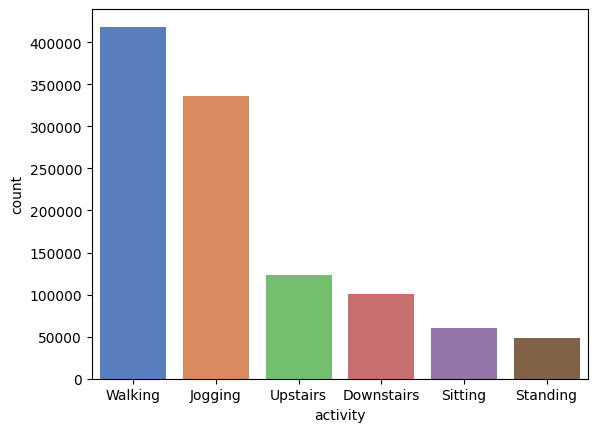

In [4]:
sns.countplot(x='activity', data=df, order = df['activity'].value_counts().index, palette="muted")
plt.show()

## Data Split

In [5]:
df_train = df[df['user_id'] <= 27].copy()
df_test = df[df['user_id'] > 27].copy()

In [6]:
print(df.shape)
print(df_train.shape)
print(df_test.shape)

(1086465, 6)
(801685, 6)
(284780, 6)


## Encoding & Normalization

In [7]:
df['x'] = df['x'] / 20.0
df['y'] = df['y'] / 20.0
df['z'] = df['z'] / 20.0

In [8]:
le = LabelEncoder()
df_train["label"] = le.fit_transform(df_train["activity"])
df_test["label"] = le.transform(df_test["activity"])

## Sliding Windows

In [9]:
def create_sliding_windows_with_group(df, window_size=80, step_size=40):
    data, labels, groups = [], [], []
    values = df[["x", "y", "z"]].values
    acts   = df["label"].values
    users  = df["user_id"].values

    for start in range(0, len(df) - window_size + 1, step_size):
        end = start + window_size
        window = values[start:end]
        label  = np.argmax(np.bincount(acts[start:end]))
        user   = users[start]

        data.append(window)
        labels.append(label)
        groups.append(user)

    return np.array(data), np.array(labels), np.array(groups)

X, y, groups = create_sliding_windows_with_group(df_train)
X_test, y_test, groups_test = create_sliding_windows_with_group(df_test)

X_test_t = torch.tensor(X_test, dtype=torch.float32)
y_test_t = torch.tensor(y_test, dtype=torch.long)
test_ds = TensorDataset(X_test_t, y_test_t)
test_loader = DataLoader(test_ds, batch_size=64, shuffle=False)

print("전체:", X.shape, y.shape, groups.shape)

전체: (20041, 80, 3) (20041,) (20041,)


## GroupKFold

In [10]:
gkf = GroupKFold(n_splits=5)

def get_fold_loaders(fold, batch_size=64):
    train_idx, val_idx = list(gkf.split(X, y, groups))[fold]

    X_train, y_train = X[train_idx], y[train_idx]
    X_val, y_val     = X[val_idx], y[val_idx]

    train_ds = TensorDataset(torch.tensor(X_train, dtype=torch.float32),
                             torch.tensor(y_train, dtype=torch.long))
    val_ds   = TensorDataset(torch.tensor(X_val, dtype=torch.float32),
                             torch.tensor(y_val, dtype=torch.long))

    train_loader = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
    val_loader   = DataLoader(val_ds, batch_size=batch_size, shuffle=False)

    return train_loader, val_loader

## Model Creation

In [11]:
class ModelA(nn.Module):
    def __init__(self, num_classes=6):
        super(ModelA, self).__init__()

        self.conv1 = nn.Conv1d(in_channels=3, out_channels=16, kernel_size=3, padding=1)
        self.bn1 = nn.BatchNorm1d(16)

        self.conv2 = nn.Conv1d(in_channels=16, out_channels=32, kernel_size=3, padding=1)
        self.bn2 = nn.BatchNorm1d(32)

        self.fc = nn.Linear(32 * 80, num_classes)

    def forward(self, x):
        x = x.permute(0, 2, 1)  # (batch, 80, 3) -> (batch,, 3, 80)

        x = F.relu(self.bn1(self.conv1(x)))
        x = F.relu(self.bn2(self.conv2(x)))

        x = x.view(x.size(0), -1)  # Flatten

        x = self.fc(x)
        return F.log_softmax(x, dim=1)

In [12]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
model = ModelA(num_classes=6).to(device)
print(device)
print(model)

cuda
ModelA(
  (conv1): Conv1d(3, 16, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn1): BatchNorm1d(16, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (conv2): Conv1d(16, 32, kernel_size=(3,), stride=(1,), padding=(1,))
  (bn2): BatchNorm1d(32, eps=1e-05, momentum=0.1, affine=True, track_running_stats=True)
  (fc): Linear(in_features=2560, out_features=6, bias=True)
)


## Model Training

In [13]:
def train_model(model, train_loader, val_loader, epochs=10):

    history = {"train_loss": [], "train_acc": [], "val_loss": [], "val_acc": []}
    
    for epoch in range(1, epochs+1):
        # --- Training ---
        model.train()
        train_loss, correct, total = 0, 0, 0
        for xb, yb in train_loader:
            xb, yb = xb.to(device), yb.to(device)
            
            optimizer.zero_grad()
            outputs = model(xb)
            loss = criterion(outputs, yb)
            loss.backward()
            optimizer.step()
            
            train_loss += loss.item() * xb.size(0)
            _, predicted = outputs.max(1)
            correct += predicted.eq(yb).sum().item()
            total += yb.size(0)
        
        train_acc = correct / total
        train_loss /= total

        # --- Validation ---
        model.eval()
        val_loss, val_correct, val_total = 0, 0, 0
        with torch.no_grad():
            for xb, yb in val_loader:
                xb, yb = xb.to(device), yb.to(device)
                outputs = model(xb)
                loss = criterion(outputs, yb)
                val_loss += loss.item() * xb.size(0)
                _, predicted = outputs.max(1)
                val_correct += predicted.eq(yb).sum().item()
                val_total += yb.size(0)
        
        val_acc = val_correct / val_total
        val_loss /= val_total

        # --- 로그 저장 ---
        history["train_loss"].append(train_loss)
        history["train_acc"].append(train_acc)
        history["val_loss"].append(val_loss)
        history["val_acc"].append(val_acc)   
        
        print(f"Epoch {epoch:02d} | "
              f"Train Loss: {train_loss:.4f}, Acc: {train_acc:.4f} | "
              f"Val Loss: {val_loss:.4f}, Acc: {val_acc:.4f}")   

    return history


===== Fold 1 =====
Epoch 01 | Train Loss: 0.6101, Acc: 0.7514 | Val Loss: 0.7685, Acc: 0.7644
Epoch 02 | Train Loss: 0.3276, Acc: 0.8909 | Val Loss: 0.9754, Acc: 0.7152
Epoch 03 | Train Loss: 0.2409, Acc: 0.9175 | Val Loss: 1.2042, Acc: 0.6942
Epoch 04 | Train Loss: 0.1986, Acc: 0.9341 | Val Loss: 1.1445, Acc: 0.7700
Epoch 05 | Train Loss: 0.1633, Acc: 0.9442 | Val Loss: 1.0349, Acc: 0.7775
Epoch 06 | Train Loss: 0.1536, Acc: 0.9494 | Val Loss: 1.8847, Acc: 0.6584
Epoch 07 | Train Loss: 0.1263, Acc: 0.9590 | Val Loss: 1.5461, Acc: 0.7327
Epoch 08 | Train Loss: 0.1138, Acc: 0.9629 | Val Loss: 1.3644, Acc: 0.7278
Epoch 09 | Train Loss: 0.0995, Acc: 0.9679 | Val Loss: 1.5207, Acc: 0.7268
Epoch 10 | Train Loss: 0.0968, Acc: 0.9694 | Val Loss: 1.4909, Acc: 0.7385
Epoch 11 | Train Loss: 0.0878, Acc: 0.9715 | Val Loss: 1.5602, Acc: 0.7493
Epoch 12 | Train Loss: 0.0877, Acc: 0.9683 | Val Loss: 1.3389, Acc: 0.7744
Epoch 13 | Train Loss: 0.0885, Acc: 0.9725 | Val Loss: 1.0514, Acc: 0.8110
Epoch

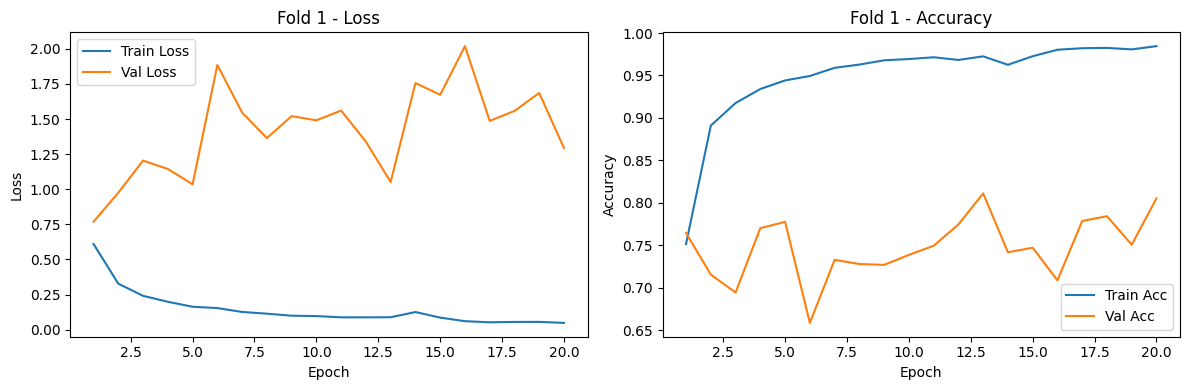

Fold 1 Accuracy: 0.8051

===== Fold 2 =====
Epoch 01 | Train Loss: 0.6162, Acc: 0.7666 | Val Loss: 0.6133, Acc: 0.7502
Epoch 02 | Train Loss: 0.3637, Acc: 0.8770 | Val Loss: 0.7114, Acc: 0.7581
Epoch 03 | Train Loss: 0.2660, Acc: 0.9115 | Val Loss: 1.2041, Acc: 0.6403
Epoch 04 | Train Loss: 0.2272, Acc: 0.9274 | Val Loss: 0.7514, Acc: 0.7607
Epoch 05 | Train Loss: 0.1951, Acc: 0.9399 | Val Loss: 0.7341, Acc: 0.7775
Epoch 06 | Train Loss: 0.1689, Acc: 0.9471 | Val Loss: 0.7758, Acc: 0.7851
Epoch 07 | Train Loss: 0.1368, Acc: 0.9581 | Val Loss: 0.8983, Acc: 0.7686
Epoch 08 | Train Loss: 0.1267, Acc: 0.9624 | Val Loss: 0.8581, Acc: 0.7734
Epoch 09 | Train Loss: 0.1220, Acc: 0.9630 | Val Loss: 0.9024, Acc: 0.7696
Epoch 10 | Train Loss: 0.1103, Acc: 0.9684 | Val Loss: 1.0178, Acc: 0.7669
Epoch 11 | Train Loss: 0.0963, Acc: 0.9718 | Val Loss: 0.8924, Acc: 0.7755
Epoch 12 | Train Loss: 0.0989, Acc: 0.9700 | Val Loss: 0.9687, Acc: 0.7602
Epoch 13 | Train Loss: 0.0913, Acc: 0.9728 | Val Loss: 0

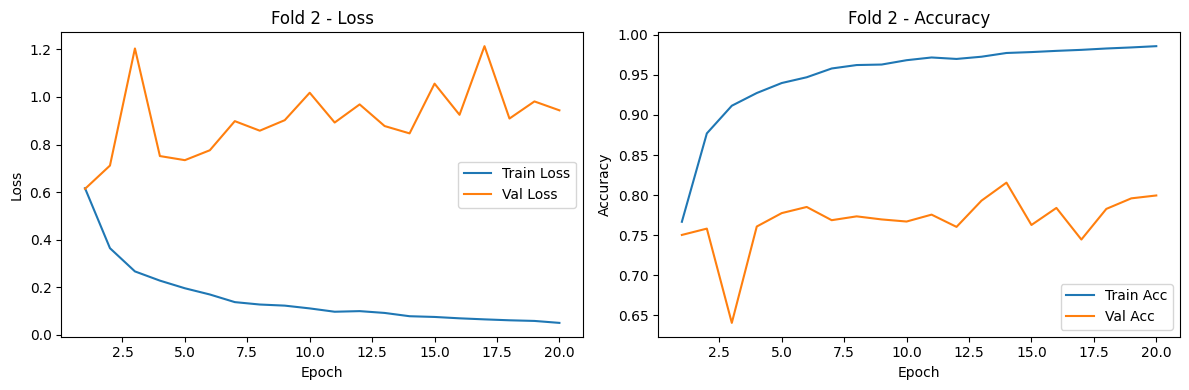

Fold 2 Accuracy: 0.7995

===== Fold 3 =====
Epoch 01 | Train Loss: 0.6390, Acc: 0.7421 | Val Loss: 0.4495, Acc: 0.8233
Epoch 02 | Train Loss: 0.3716, Acc: 0.8659 | Val Loss: 0.4136, Acc: 0.8413
Epoch 03 | Train Loss: 0.2774, Acc: 0.9070 | Val Loss: 0.5374, Acc: 0.8095
Epoch 04 | Train Loss: 0.2415, Acc: 0.9193 | Val Loss: 0.5867, Acc: 0.8008
Epoch 05 | Train Loss: 0.2025, Acc: 0.9329 | Val Loss: 0.6137, Acc: 0.8039
Epoch 06 | Train Loss: 0.1796, Acc: 0.9414 | Val Loss: 0.6636, Acc: 0.7878
Epoch 07 | Train Loss: 0.1560, Acc: 0.9512 | Val Loss: 0.7255, Acc: 0.7865
Epoch 08 | Train Loss: 0.1319, Acc: 0.9573 | Val Loss: 0.6439, Acc: 0.8021
Epoch 09 | Train Loss: 0.1191, Acc: 0.9634 | Val Loss: 0.6034, Acc: 0.8159
Epoch 10 | Train Loss: 0.1187, Acc: 0.9623 | Val Loss: 0.7806, Acc: 0.7829
Epoch 11 | Train Loss: 0.1100, Acc: 0.9626 | Val Loss: 0.6999, Acc: 0.8021
Epoch 12 | Train Loss: 0.1003, Acc: 0.9674 | Val Loss: 1.0664, Acc: 0.7535
Epoch 13 | Train Loss: 0.1120, Acc: 0.9619 | Val Loss: 0

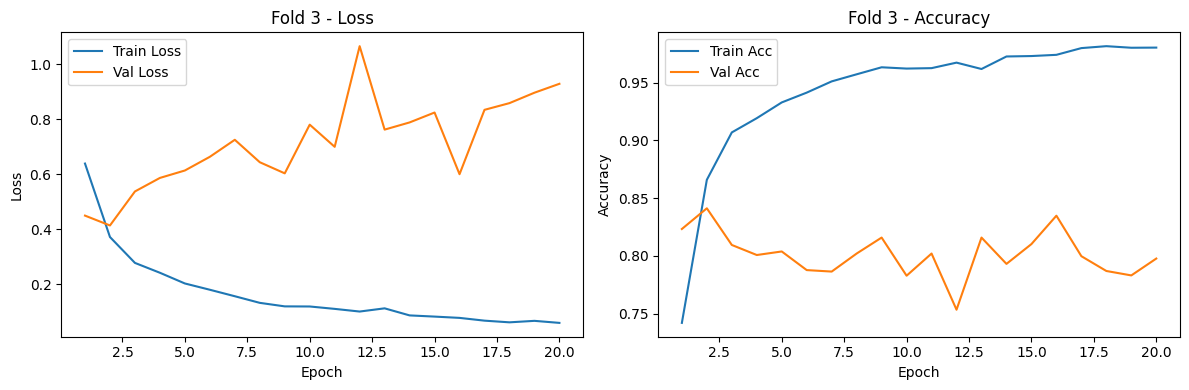

Fold 3 Accuracy: 0.7977

===== Fold 4 =====
Epoch 01 | Train Loss: 0.5681, Acc: 0.7740 | Val Loss: 0.8727, Acc: 0.7452
Epoch 02 | Train Loss: 0.3321, Acc: 0.8793 | Val Loss: 0.8483, Acc: 0.7750
Epoch 03 | Train Loss: 0.2695, Acc: 0.9056 | Val Loss: 0.9051, Acc: 0.7059
Epoch 04 | Train Loss: 0.2215, Acc: 0.9251 | Val Loss: 1.3035, Acc: 0.6269
Epoch 05 | Train Loss: 0.1835, Acc: 0.9386 | Val Loss: 0.9457, Acc: 0.7188
Epoch 06 | Train Loss: 0.1722, Acc: 0.9422 | Val Loss: 1.0245, Acc: 0.6958
Epoch 07 | Train Loss: 0.1457, Acc: 0.9519 | Val Loss: 1.4206, Acc: 0.7306
Epoch 08 | Train Loss: 0.1255, Acc: 0.9594 | Val Loss: 1.1128, Acc: 0.6987
Epoch 09 | Train Loss: 0.1185, Acc: 0.9623 | Val Loss: 1.5012, Acc: 0.6773
Epoch 10 | Train Loss: 0.1038, Acc: 0.9678 | Val Loss: 1.0900, Acc: 0.7426
Epoch 11 | Train Loss: 0.1173, Acc: 0.9619 | Val Loss: 1.3835, Acc: 0.6883
Epoch 12 | Train Loss: 0.0869, Acc: 0.9738 | Val Loss: 1.2364, Acc: 0.7205
Epoch 13 | Train Loss: 0.0784, Acc: 0.9771 | Val Loss: 1

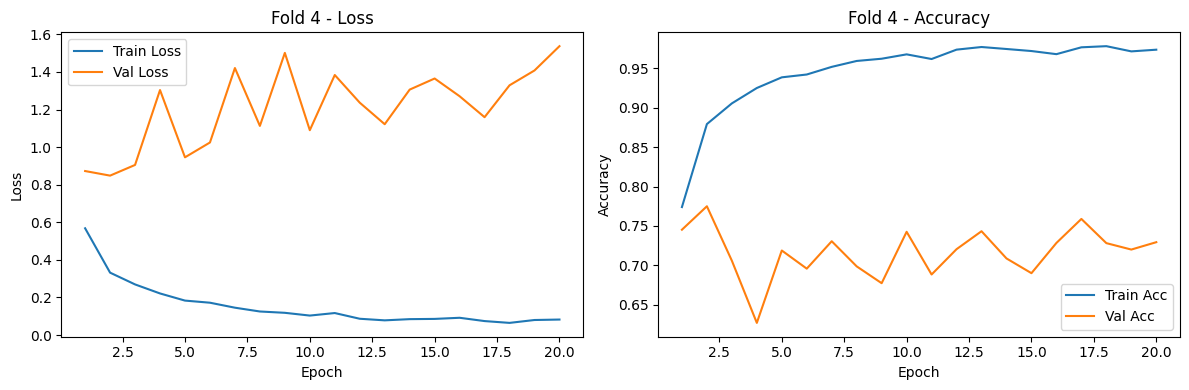

Fold 4 Accuracy: 0.7294

===== Fold 5 =====
Epoch 01 | Train Loss: 0.6845, Acc: 0.7174 | Val Loss: 0.4882, Acc: 0.8272
Epoch 02 | Train Loss: 0.3986, Acc: 0.8525 | Val Loss: 0.3092, Acc: 0.9057
Epoch 03 | Train Loss: 0.3004, Acc: 0.8947 | Val Loss: 0.2713, Acc: 0.9070
Epoch 04 | Train Loss: 0.2416, Acc: 0.9177 | Val Loss: 0.2510, Acc: 0.9178
Epoch 05 | Train Loss: 0.2038, Acc: 0.9302 | Val Loss: 0.2306, Acc: 0.9122
Epoch 06 | Train Loss: 0.1656, Acc: 0.9447 | Val Loss: 0.2390, Acc: 0.9163
Epoch 07 | Train Loss: 0.1462, Acc: 0.9543 | Val Loss: 0.2359, Acc: 0.9178
Epoch 08 | Train Loss: 0.1377, Acc: 0.9563 | Val Loss: 0.2345, Acc: 0.9196
Epoch 09 | Train Loss: 0.1269, Acc: 0.9567 | Val Loss: 0.2484, Acc: 0.9184
Epoch 10 | Train Loss: 0.1215, Acc: 0.9619 | Val Loss: 0.2594, Acc: 0.9122
Epoch 11 | Train Loss: 0.1032, Acc: 0.9666 | Val Loss: 0.2851, Acc: 0.9027
Epoch 12 | Train Loss: 0.0908, Acc: 0.9730 | Val Loss: 0.2447, Acc: 0.9168
Epoch 13 | Train Loss: 0.0850, Acc: 0.9741 | Val Loss: 0

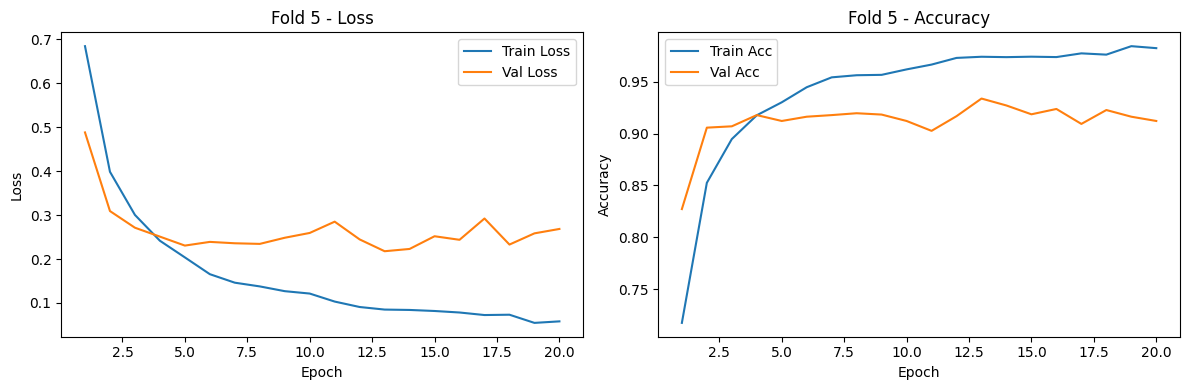

Fold 5 Accuracy: 0.9122

=== K-Fold 평균 정확도 ===
Mean Acc: 0.8088, Std: 0.0587


In [14]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

best_val_acc = 0.0
best_model_state = None
best_class_weights = None

fold_accs = []
for fold in range(5):
    print(f"\n===== Fold {fold+1} =====")
    train_loader, val_loader = get_fold_loaders(fold, batch_size=64)
    
    model = ModelA(num_classes=6).to(device)
    optimizer = torch.optim.Adam(model.parameters(), lr=1e-3)

    # 클래스 가중치 (train fold 기준)
    y_train_fold = np.array([y for _, y in train_loader.dataset])
    classes, counts = np.unique(y_train_fold, return_counts=True)
    weights = (counts.sum() / (len(classes) * counts)).astype(np.float32)
    class_weights = torch.tensor(weights, dtype=torch.float32).to(device)
    criterion = nn.CrossEntropyLoss(weight=class_weights)

    # 학습 (히스토리 저장)
    history = train_model(model, train_loader, val_loader, epochs=20)

    # 시각화
    epochs = range(1, len(history["train_loss"])+1)
    plt.figure(figsize=(12,4))

    # fold 최고 성능 기록
    val_acc = max(history["val_acc"])
    if val_acc > best_val_acc:
        best_val_acc = val_acc
        best_model_state = model.state_dict()
        best_class_weights = class_weights
        
    # Loss 곡선
    plt.subplot(1,2,1)
    plt.plot(epochs, history["train_loss"], label="Train Loss")
    plt.plot(epochs, history["val_loss"], label="Val Loss")
    plt.title(f"Fold {fold+1} - Loss")
    plt.xlabel("Epoch")
    plt.ylabel("Loss")
    plt.legend()
    plt.grid(False)

    # Accuracy 곡선
    plt.subplot(1,2,2)
    plt.plot(epochs, history["train_acc"], label="Train Acc")
    plt.plot(epochs, history["val_acc"], label="Val Acc")
    plt.title(f"Fold {fold+1} - Accuracy")
    plt.xlabel("Epoch")
    plt.ylabel("Accuracy")
    plt.legend()
    plt.grid(False)

    plt.tight_layout()
    plt.show()
    
    # fold 성능 저장
    val_correct, val_total = 0, 0
    with torch.no_grad():
        for xb, yb in val_loader:
            xb, yb = xb.to(device), yb.to(device)
            outputs = model(xb)
            _, predicted = outputs.max(1)
            val_correct += predicted.eq(yb).sum().item()
            val_total += yb.size(0)
    acc = val_correct / val_total
    print(f"Fold {fold+1} Accuracy: {acc:.4f}")
    fold_accs.append(acc)

print("\n=== K-Fold 평균 정확도 ===")
print(f"Mean Acc: {np.mean(fold_accs):.4f}, Std: {np.std(fold_accs):.4f}")

## Check class distribution by Fold

In [15]:
# Fold별 class 분포 확인
for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    y_val = y[val_idx]
    counts = pd.Series(y_val).value_counts(normalize=True).sort_index()
    print(f"\nFold {fold+1} Validation Set Class Distribution:")
    for cls_idx, ratio in counts.items():
        print(f"  Class {cls_idx}: {ratio:.2%}")


Fold 1 Validation Set Class Distribution:
  Class 0: 8.32%
  Class 1: 30.35%
  Class 2: 13.55%
  Class 3: 6.84%
  Class 4: 8.94%
  Class 5: 32.01%

Fold 2 Validation Set Class Distribution:
  Class 0: 6.96%
  Class 1: 30.82%
  Class 2: 4.19%
  Class 3: 3.59%
  Class 4: 9.52%
  Class 5: 44.92%

Fold 3 Validation Set Class Distribution:
  Class 0: 7.94%
  Class 1: 35.69%
  Class 2: 3.81%
  Class 3: 4.97%
  Class 4: 9.83%
  Class 5: 37.76%

Fold 4 Validation Set Class Distribution:
  Class 0: 10.68%
  Class 1: 28.77%
  Class 2: 3.02%
  Class 3: 1.92%
  Class 4: 15.76%
  Class 5: 39.85%

Fold 5 Validation Set Class Distribution:
  Class 0: 10.76%
  Class 1: 35.05%
  Class 2: 1.80%
  Class 3: 2.86%
  Class 4: 12.41%
  Class 5: 37.11%


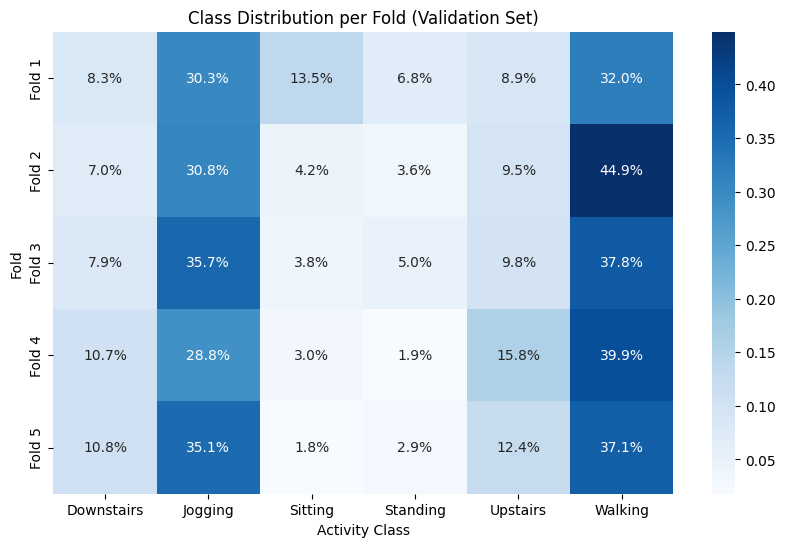

In [16]:
import matplotlib.pyplot as plt
import seaborn as sns

dist_per_fold = []

for fold, (train_idx, val_idx) in enumerate(gkf.split(X, y, groups)):
    y_val = y[val_idx]
    counts = pd.Series(y_val).value_counts(normalize=True).sort_index()
    dist_per_fold.append(counts)

dist_df = pd.DataFrame(dist_per_fold).fillna(0)
dist_df.index = [f"Fold {i+1}" for i in range(len(dist_df))]
dist_df.columns = le.classes_  # activity 이름으로 열 바꾸기

plt.figure(figsize=(10,6))
sns.heatmap(dist_df, annot=True, fmt=".1%", cmap="Blues")
plt.title("Class Distribution per Fold (Validation Set)")
plt.ylabel("Fold")
plt.xlabel("Activity Class")
plt.show()

## Model Evaluation

In [17]:
# test
def test_loop(model, test_loader, criterion, device="cpu"):
    model.eval()  # 평가 모드 (Dropout/BatchNorm 비활성화)
    test_loss, correct, total = 0.0, 0, 0
    all_preds, all_labels = [], []

    with torch.no_grad():  # 테스트 시에는 gradient 계산 끔
        for xb, yb in test_loader:
            xb, yb = xb.to(device), yb.to(device)

            # forward
            outputs = model(xb)
            loss = criterion(outputs, yb)

            # 손실 누적 (평균 내기 위해 샘플 수 곱해줌)
            test_loss += loss.item() * xb.size(0)

            # 예측값
            _, predicted = outputs.max(1)
            correct += predicted.eq(yb).sum().item()
            total += yb.size(0)
            
            all_preds.extend(predicted.cpu().numpy())
            all_labels.extend(yb.cpu().numpy())
    
    avg_loss = test_loss / total
    acc = correct / total
    return avg_loss, acc, np.array(all_preds), np.array(all_labels)

In [18]:
device = "cuda" if torch.cuda.is_available() else "cpu"

model = ModelA(num_classes=6).to(device)
model.load_state_dict(best_model_state)

criterion = nn.CrossEntropyLoss(weight=best_class_weights)

test_loss, test_acc, all_preds, all_labels = test_loop(model, test_loader, criterion, device)

print(f"Test Loss: {test_loss:.4f}, Test Accuracy: {test_acc:.4f}")

Test Loss: 1.1710, Test Accuracy: 0.7527


In [19]:
all_preds, all_labels = [], []
model.eval()
with torch.no_grad():
    for xb, yb in test_loader:
        xb, yb = xb.to(device), yb.to(device)
        outputs = model(xb)
        _, predicted = outputs.max(1)
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(yb.cpu().numpy())

all_preds = np.array(all_preds)
all_labels = np.array(all_labels)

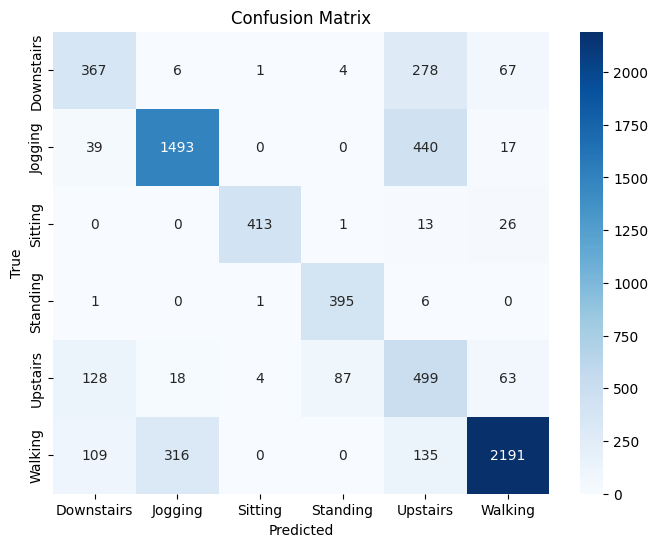

In [20]:
cm = confusion_matrix(all_labels, all_preds)

plt.figure(figsize=(8,6))
sns.heatmap(cm, annot=True, fmt="d", cmap="Blues",
            xticklabels=le.classes_, yticklabels=le.classes_)
plt.xlabel("Predicted")
plt.ylabel("True")
plt.title("Confusion Matrix")
plt.show()

In [21]:
print(classification_report(all_labels, all_preds, target_names=le.classes_))

              precision    recall  f1-score   support

  Downstairs       0.57      0.51      0.54       723
     Jogging       0.81      0.75      0.78      1989
     Sitting       0.99      0.91      0.95       453
    Standing       0.81      0.98      0.89       403
    Upstairs       0.36      0.62      0.46       799
     Walking       0.93      0.80      0.86      2751

    accuracy                           0.75      7118
   macro avg       0.75      0.76      0.74      7118
weighted avg       0.79      0.75      0.77      7118

